# 1.0 Model Creation and Training

In [1]:
#installing necessary libraries
!pip install yfinance
!pip install findspark
!pip install pyspark
!pip install vaderSentiment

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.8/310.8 MB 3.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.4.0-py2.py3-none-any.whl size=311317130 sha256=056fc4d7cd7c7f2ec3d1773c7c557d0a5e9f46b8f5c0fc74980683c43a989be1
  Stored in directory: /root/.cache/pip/wheels/7b/1b/4b/3363a1d04368e7ff0d408e57ff57966fcdf00583774e761327
Successfully built pyspark
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 4.9 MB/s eta 0:00:00


In [2]:
import pandas as pd
import csv
import datetime
import yfinance as yf
import numpy as np
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from bs4 import BeautifulSoup as bs
import requests
from pyspark.sql.functions import sum,max,min,mean,count
import datetime as dt
import pyspark
from pyspark.sql import SparkSession
import findspark
import yaml
from yaml.loader import SafeLoader
from os.path import abspath
!git clone https://github.com/JollygreenG-10/BigData.git

Cloning into 'BigData'...
remote: Enumerating objects: 142, done.
remote: Counting objects: 100% (65/65), done.
remote: Compressing objects: 100% (51/51), done.
remote: Total 142 (delta 17), reused 55 (delta 14), pack-reused 77
Receiving objects: 100% (142/142), 8.84 MiB | 14.41 MiB/s, done.
Resolving deltas: 100% (47/47), done.


## 1.1 Read in CSV Files Containing Data for Target Companies

In [3]:
from os import listdir
import pandas as pd
path = '/content/BigData/Project_Deliverables_PansyAhmed_AdamGreen/data/'

from sklearn.preprocessing import MinMaxScaler
#Function to read in csv files and scale columns for data where scaling of predictions is eventually needed
def scale(path):
    scaler_list = []
    target_list = []
    feat_list = []
    for item in listdir(path):
        df = pd.read_csv(path + str(item))
        print(str(item))
        df['date'] = pd.to_datetime(df['date'])
        df = df.set_index('date')
        #create scaler instances
        scaler = MinMaxScaler(feature_range=(0,1))
        target_scaler = MinMaxScaler(feature_range = (0,1))
        data = df.drop(['ticker'],axis=1)
        # scale features and target columns
        target = target_scaler.fit_transform(data[['target']])
        target = target.flatten()
        scaler_list.append(target_scaler)
        target_list.append(target)
        X_feat = data.drop(['target'], axis = 1)
        for col in X_feat.columns:
            X_feat[col] = scaler.fit_transform(X_feat[[col]])
        feat_list.append(X_feat)
    return scaler_list, target_list, feat_list
scaler_list, target_list, feat_list = scale(path) 

MSFT_dataframe.csv
GOOG_dataframe.csv


In [4]:
#Split training and test data (microsoft and google) was well as features and targets
test_data = feat_list[1]   
test_target = target_list[1]
train_data = feat_list[0] 
train_target = target_list[0]
print(train_data.reset_index().info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1802 entries, 0 to 1801
Data columns (total 19 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   date        1802 non-null   datetime64[ns]
 1   open        1802 non-null   float64       
 2   high        1802 non-null   float64       
 3   low         1802 non-null   float64       
 4   close       1802 non-null   float64       
 5   adj_close   1802 non-null   float64       
 6   volume      1802 non-null   float64       
 7   tenmda      1802 non-null   float64       
 8   twentymda   1802 non-null   float64       
 9   fiftymda    1802 non-null   float64       
 10  hundredmda  1802 non-null   float64       
 11  EWMA_20     1802 non-null   float64       
 12  EWMA_50     1802 non-null   float64       
 13  EWMA_100    1802 non-null   float64       
 14  rsi         1802 non-null   float64       
 15  MiddleBand  1802 non-null   float64       
 16  UpperBand   1802 non-nul

In [5]:
# Split data into X_train and y_train data sets
import numpy as np
def lstm_split(data,target,steps):
      X = []
      y = []
      # Creating a data structure with 10 time-steps and 1 output
      for i in range(10, steps):
          X.append(data[i-10:i])
          y.append(target[i])  
      return np.array(X),np.array(y)
 
X1,y1 = lstm_split(train_data, train_target,len(train_data))

#Define Training and Test Datasets
def train_split(x1, y1, train_data):
  train_split = 0.9
  split_idx = int(np.ceil(len(X1)*train_split))
  date_index = train_data.index
 
  X_train,X_test = X1[:split_idx],X1[split_idx:]
  y_train,y_test = y1[:split_idx],y1[split_idx:]
  X_train_date,X_test_date = date_index[:split_idx],date_index[split_idx:]
  return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = train_split(X1, y1, train_data)
print(X1.shape,X_train.shape,X_test.shape,y_test.shape,y_train.shape)

(1792, 10, 18) (1613, 10, 18) (179, 10, 18) (179,) (1613,)


# 2.0 Setup the models LSTM & Prophet models for a single stock 

## 2.1 Configure the base LSTM model 
This process involved running a random search function to select best hyperparameters for the network. The results of this search are availble below.


In [ ]:
!pip install tensorflow
import keras
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import LSTM
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras.metrics import Precision
from keras.optimizers import Adam
!pip install keras_tuner
import keras_tuner

#define function to create model, optional hyperparameters included to be selected during training
LR = 0.05
def build_model(hp):
  model = Sequential()
  hidden = hp.Choice('n_hidden', [0,1,2,3])
  model.add(LSTM(units = hp.Int('neurons_visible', min_value = X_train.shape[2], max_value = 100, step = 20),
                activation = hp.Choice('activate1', ['sigmoid', 'relu']),
                input_shape = (X_train.shape[1], X_train.shape[2]),
                return_sequences = True if hidden >0 else False))
  #Configure hidden layers based on random search determined hidden layer number
  if hidden > 0:
    for num in range(hidden):
      model.add(Dropout(hp.Float('dropout' +str(num+1), min_value = 0.1, max_value = 0.9, step = 0.3)))
      model.add(LSTM(units = hp.Int('neurons_hidden'+str(num+1), min_value = 20, max_value = 50, step = 10),
                     activation = 'relu', return_sequences = True if num != hidden else False))
      
  model.add(Dropout(0.5))
  model.add(Dense(units = 1, activation = 'sigmoid'))

  #compile the model
  model.compile(loss = 'mean_squared_error', optimizer = Adam(lr = LR), metrics = ['mae'])
  
  return model

#set learning rate and early stopping callbacks
LR_decay = ReduceLROnPlateau('loss', patience=1, verbose=0, 
                             factor=0.5, min_lr=1e-8)
Early_stop = EarlyStopping(monitor='loss', min_delta=0, 
                           patience=25, verbose=1, mode='auto',
                           baseline=0, restore_best_weights=True)
#arrange random search class
tune = keras_tuner.RandomSearch(build_model, objective = 'val_loss', max_trials = 25, seed = 1)

#complete training 
tune.search(X_train, y_train, epochs = 200, batch_size = 20, validation_data = (X_test, y_test), callbacks = [LR_decay, Early_stop])

LSTM_model = tune.get_best_models()[0]
LSTM_model.save('main_models/LSTM_model1.h5')
hyperparameters = tune.get_best_hyperparameters()[0]
print(hyperparameters.values)

Trial 20 Complete [00h 00m 52s]
val_loss: 0.10508779436349869

Best val_loss So Far: 0.000685187871567905
Total elapsed time: 00h 16m 19s

Search: Running Trial #21

Value             |Best Value So Far |Hyperparameter
2                 |0                 |n_hidden
78                |58                |neurons_visible
sigmoid           |sigmoid           |activate1
0.1               |0.7               |dropout1
40                |50                |neurons_hidden1
0.1               |0.4               |dropout2
40                |20                |neurons_hidden2
0.1               |0.7               |dropout3
20                |40                |neurons_hidden3

Epoch 1/200
55/81 [===================>..........] - ETA: 0s - loss: 0.0898 - mae: 0.2540

# Test Base LSTM Model on Microsoft Validation Data

In [8]:
# function to test LSTM predictions
def testmodel(m_path, trainset ):
  from keras.models import load_model
  model = load_model(m_path)
  m_pred = model.predict(trainset)
  print(m_pred.shape)
  return m_pred

In [9]:
#test LSTM model using X_train for MSFT
LSTM_MSFT_test = testmodel('main_models/LSTM_model1.h5', X_test)
LSTM_MSFT_test.shape
LSTM_MSFT_pre_saved = testmodel('/content/BigData/Project_Deliverables_PansyAhmed_AdamGreen/main_models/LSTM_model1.h5', X_test)

6/6 [==============================] - 0s 5ms/step
(179, 1)


6/6 [==============================] - 0s 8ms/step
(179, 1)


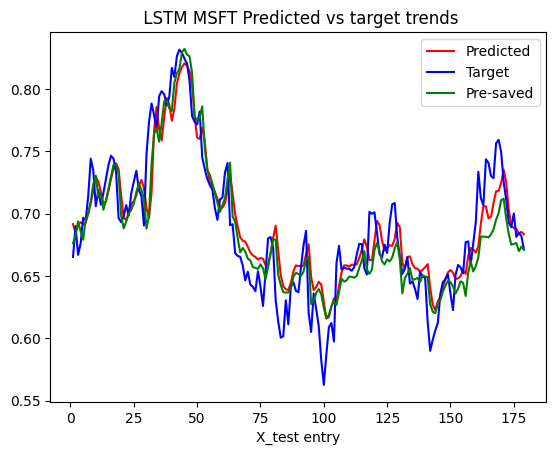

In [10]:
import matplotlib.pyplot as plt
x=np.arange(1,len(y_test)+1, 1)
plt.plot(x,LSTM_MSFT_test.flatten(), "r", label= "Predicted")
plt.plot(x,y_test, "b", label= "Target")
plt.plot(x, LSTM_MSFT_pre_saved.flatten(), 'green', label = 'Pre-saved')
#plt.plot(x, LSTM_MSFT_long.flatten(), 'orange', label = 'long_train')
plt.title(" LSTM MSFT Predicted vs target trends")
plt.xlabel('X_test entry')
plt.legend()
plt.show()

## 2.2 Configure the Prophet Model

In [31]:
from prophet import Prophet
from sklearn.metrics import mean_squared_error
from prophet.diagnostics import cross_validation, performance_metrics
from sklearn.model_selection import ParameterGrid
import yfinance as yf
import datetime as dt

#Generate basic financial data from yfinance for prophet training
def prophet_data(ticker, start_day, month, year):
    delta = dt.timedelta(days = 150)
    data = yf.download(ticker, (dt.date(year, month, start_day) - delta)).reset_index()
    print(data.head())
    data = data.rename(columns = {'Date':'ds', 'Open':'open', 'High':'high', 'Low':'low', 'Close':'y', 'Adj Close': 'adj_close', 'Volume':'volume'})
    print(data.head())
    data = data.loc[:,['ds', 'y']]
    return data

MSFT_data = prophet_data('MSFT',1, 1,2016)
GOOG_data = prophet_data('GOOG', 1, 1, 2016)


[*********************100%***********************]  1 of 1 completed
        Date       Open       High        Low      Close  Adj Close    Volume
0 2015-08-04  46.750000  47.709999  46.680000  47.540001  41.953972  33403900
1 2015-08-05  47.980000  48.410000  47.540001  47.580002  41.989281  26959700
2 2015-08-06  47.709999  47.770000  46.330002  46.619999  41.142082  27368000
3 2015-08-07  46.389999  46.779999  46.259998  46.740002  41.247978  19163000
4 2015-08-10  46.950001  47.490002  46.840000  47.330002  41.768658  23079900
          ds       open       high        low          y  adj_close    volume
0 2015-08-04  46.750000  47.709999  46.680000  47.540001  41.953972  33403900
1 2015-08-05  47.980000  48.410000  47.540001  47.580002  41.989281  26959700
2 2015-08-06  47.709999  47.770000  46.330002  46.619999  41.142082  27368000
3 2015-08-07  46.389999  46.779999  46.259998  46.740002  41.247978  19163000
4 2015-08-10  46.950001  47.490002  46.840000  47.330002  41.768658  2307

In [18]:
# Define parameter grid to search over
param_grid = {
    'seasonality_mode': ['additive', 'multiplicative'],
    'changepoint_prior_scale': [0.01, 0.1, 1.0],
    'seasonality_prior_scale': [0.01, 0.1, 1.0],
}

# Initialize minimum error and best parameters
min_error = float('inf')
best_params = {}

# Loop through all parameter combinations
for params in ParameterGrid(param_grid):
    print('Testing parameters:', params)

    # Initialize Prophet model with specified hyperparameters
    model = Prophet(**params)
    model.fit(MSFT_data)

    # Perform time series cross-validation
    df_cv = cross_validation(model=model, initial='1000 days', horizon='10 days', period='10 days')

    # Calculate performance metrics
    df_metrics = performance_metrics(df_cv)

    # Calculate mean cross-validation error
    mean_cv_error = df_metrics['mse'].mean()

    # Update minimum error and best parameters if new minimum is found
    if mean_cv_error < min_error:
        min_error = mean_cv_error
        best_params = params

# Print best hyperparameters and corresponding error
print('Best parameters:', best_params)
print('Minimum cross-validation error:', min_error)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpoqmy6vac/n1jgw7cw.json


Testing parameters: {'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpoqmy6vac/gq7a8u7v.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=82530', 'data', 'file=/tmp/tmpoqmy6vac/n1jgw7cw.json', 'init=/tmp/tmpoqmy6vac/gq7a8u7v.json', 'output', 'file=/tmp/tmpoqmy6vac/prophet_modela2int55r/prophet_model-20230513230732.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
23:07:32 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
23:07:33 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 183 forecasts with cutoffs between 2018-05-08 00:00:00 and 2023-05-02 00:00:00


  0%|          | 0/183 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpoqmy6vac/ob3nwwol.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpoqmy6vac/syis_wog.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=10599', 'data', 'file=/tmp/tmpoqmy6vac/ob3nwwol.json', 'init=/tmp/tmpoqmy6vac/syis_wog.json', 'output', 'file=/tmp/tmpoqmy6vac/prophet_modelql36me5_/prophet_model-20230513230734.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
23:07:34 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
23:07:34 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpoqmy6vac/ub3ccmi7.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpoqmy6vac/3kw_05ka.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

Testing parameters: {'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.1}


23:09:13 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 183 forecasts with cutoffs between 2018-05-08 00:00:00 and 2023-05-02 00:00:00


  0%|          | 0/183 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpoqmy6vac/fgn_57wk.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpoqmy6vac/ripahvka.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=24331', 'data', 'file=/tmp/tmpoqmy6vac/fgn_57wk.json', 'init=/tmp/tmpoqmy6vac/ripahvka.json', 'output', 'file=/tmp/tmpoqmy6vac/prophet_modelm6cdiv09/prophet_model-20230513230913.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
23:09:13 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
23:09:13 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpoqmy6vac/_bcmh60a.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpoqmy6vac/oxp697yw.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

Testing parameters: {'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1.0}


23:10:50 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 183 forecasts with cutoffs between 2018-05-08 00:00:00 and 2023-05-02 00:00:00


  0%|          | 0/183 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpoqmy6vac/z_j8hxgo.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpoqmy6vac/c075quim.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=96414', 'data', 'file=/tmp/tmpoqmy6vac/z_j8hxgo.json', 'init=/tmp/tmpoqmy6vac/c075quim.json', 'output', 'file=/tmp/tmpoqmy6vac/prophet_modelz_ipostf/prophet_model-20230513231051.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
23:10:51 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
23:10:51 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpoqmy6vac/cxx5rcvv.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpoqmy6vac/gxh8h7z3.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

Testing parameters: {'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01}


23:12:31 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 183 forecasts with cutoffs between 2018-05-08 00:00:00 and 2023-05-02 00:00:00


  0%|          | 0/183 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpoqmy6vac/gozhec9a.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpoqmy6vac/t7_mh9i9.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=47005', 'data', 'file=/tmp/tmpoqmy6vac/gozhec9a.json', 'init=/tmp/tmpoqmy6vac/t7_mh9i9.json', 'output', 'file=/tmp/tmpoqmy6vac/prophet_model1wnnexiv/prophet_model-20230513231231.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
23:12:31 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
23:12:31 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpoqmy6vac/4d9l38gt.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpoqmy6vac/apg0lkpm.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

Testing parameters: {'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.1}


23:14:22 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 183 forecasts with cutoffs between 2018-05-08 00:00:00 and 2023-05-02 00:00:00


  0%|          | 0/183 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpoqmy6vac/p2jg593p.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpoqmy6vac/wtoft7i4.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=13914', 'data', 'file=/tmp/tmpoqmy6vac/p2jg593p.json', 'init=/tmp/tmpoqmy6vac/wtoft7i4.json', 'output', 'file=/tmp/tmpoqmy6vac/prophet_modely57u7epl/prophet_model-20230513231422.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
23:14:23 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
23:14:23 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpoqmy6vac/jhuut25x.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpoqmy6vac/2vbsrhww.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

Testing parameters: {'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 1.0}


23:16:41 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 183 forecasts with cutoffs between 2018-05-08 00:00:00 and 2023-05-02 00:00:00


  0%|          | 0/183 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpoqmy6vac/wjune7ub.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpoqmy6vac/wng9pp2v.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=49005', 'data', 'file=/tmp/tmpoqmy6vac/wjune7ub.json', 'init=/tmp/tmpoqmy6vac/wng9pp2v.json', 'output', 'file=/tmp/tmpoqmy6vac/prophet_model4fb1m6hd/prophet_model-20230513231641.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
23:16:41 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
23:16:42 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpoqmy6vac/qn8tzztk.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpoqmy6vac/9jnd0k14.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

Testing parameters: {'changepoint_prior_scale': 0.1, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01}


23:20:07 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 183 forecasts with cutoffs between 2018-05-08 00:00:00 and 2023-05-02 00:00:00


  0%|          | 0/183 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpoqmy6vac/del6tf5r.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpoqmy6vac/gonahh8g.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=12030', 'data', 'file=/tmp/tmpoqmy6vac/del6tf5r.json', 'init=/tmp/tmpoqmy6vac/gonahh8g.json', 'output', 'file=/tmp/tmpoqmy6vac/prophet_modelr6bll4ct/prophet_model-20230513232008.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
23:20:08 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
23:20:09 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpoqmy6vac/xr8uhme0.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpoqmy6vac/pjo4wfie.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

Testing parameters: {'changepoint_prior_scale': 0.1, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.1}


23:24:14 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 183 forecasts with cutoffs between 2018-05-08 00:00:00 and 2023-05-02 00:00:00


  0%|          | 0/183 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpoqmy6vac/_n28zh1o.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpoqmy6vac/e75a6emn.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=56620', 'data', 'file=/tmp/tmpoqmy6vac/_n28zh1o.json', 'init=/tmp/tmpoqmy6vac/e75a6emn.json', 'output', 'file=/tmp/tmpoqmy6vac/prophet_modelchl0ttum/prophet_model-20230513232415.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
23:24:15 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
23:24:16 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpoqmy6vac/dbiv2956.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpoqmy6vac/0mowtql3.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

Testing parameters: {'changepoint_prior_scale': 0.1, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1.0}


23:28:30 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 183 forecasts with cutoffs between 2018-05-08 00:00:00 and 2023-05-02 00:00:00


  0%|          | 0/183 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpoqmy6vac/o37v2sj6.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpoqmy6vac/aelh8ksm.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=65439', 'data', 'file=/tmp/tmpoqmy6vac/o37v2sj6.json', 'init=/tmp/tmpoqmy6vac/aelh8ksm.json', 'output', 'file=/tmp/tmpoqmy6vac/prophet_modelv675co9l/prophet_model-20230513232830.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
23:28:30 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
23:28:31 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpoqmy6vac/ettv7tua.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpoqmy6vac/le3ln3p7.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

Testing parameters: {'changepoint_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpoqmy6vac/229xnuc4.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=87376', 'data', 'file=/tmp/tmpoqmy6vac/alkxmlbo.json', 'init=/tmp/tmpoqmy6vac/229xnuc4.json', 'output', 'file=/tmp/tmpoqmy6vac/prophet_model4ml_fshp/prophet_model-20230513233237.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
23:32:37 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
23:32:39 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 183 forecasts with cutoffs between 2018-05-08 00:00:00 and 2023-05-02 00:00:00


  0%|          | 0/183 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpoqmy6vac/c_hqtnvd.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpoqmy6vac/bt_iquo7.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=79013', 'data', 'file=/tmp/tmpoqmy6vac/c_hqtnvd.json', 'init=/tmp/tmpoqmy6vac/bt_iquo7.json', 'output', 'file=/tmp/tmpoqmy6vac/prophet_model91fln6ah/prophet_model-20230513233239.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
23:32:39 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
23:32:40 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpoqmy6vac/syir9gsv.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpoqmy6vac/auig3ik4.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

Testing parameters: {'changepoint_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.1}


23:36:47 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 183 forecasts with cutoffs between 2018-05-08 00:00:00 and 2023-05-02 00:00:00


  0%|          | 0/183 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpoqmy6vac/a7f3yl92.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpoqmy6vac/upc9fbhw.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=61789', 'data', 'file=/tmp/tmpoqmy6vac/a7f3yl92.json', 'init=/tmp/tmpoqmy6vac/upc9fbhw.json', 'output', 'file=/tmp/tmpoqmy6vac/prophet_model65jorgw9/prophet_model-20230513233648.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
23:36:48 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
23:36:48 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpoqmy6vac/ac4yzujb.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpoqmy6vac/jjsr4c49.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

Testing parameters: {'changepoint_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 1.0}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpoqmy6vac/edtmhdfa.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=99443', 'data', 'file=/tmp/tmpoqmy6vac/3m55qcvx.json', 'init=/tmp/tmpoqmy6vac/edtmhdfa.json', 'output', 'file=/tmp/tmpoqmy6vac/prophet_model_7_rm8xd/prophet_model-20230513234111.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
23:41:11 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
23:41:15 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 183 forecasts with cutoffs between 2018-05-08 00:00:00 and 2023-05-02 00:00:00


  0%|          | 0/183 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpoqmy6vac/djayg0u0.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpoqmy6vac/37tmywou.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=11985', 'data', 'file=/tmp/tmpoqmy6vac/djayg0u0.json', 'init=/tmp/tmpoqmy6vac/37tmywou.json', 'output', 'file=/tmp/tmpoqmy6vac/prophet_modelo6nngbkc/prophet_model-20230513234116.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
23:41:16 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
23:41:17 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpoqmy6vac/15g18ozg.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpoqmy6vac/3tub55pb.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

Testing parameters: {'changepoint_prior_scale': 1.0, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01}


23:48:39 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 183 forecasts with cutoffs between 2018-05-08 00:00:00 and 2023-05-02 00:00:00


  0%|          | 0/183 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpoqmy6vac/jj6uiha9.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpoqmy6vac/fzam3an8.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=30514', 'data', 'file=/tmp/tmpoqmy6vac/jj6uiha9.json', 'init=/tmp/tmpoqmy6vac/fzam3an8.json', 'output', 'file=/tmp/tmpoqmy6vac/prophet_modeltldz8e31/prophet_model-20230513234839.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
23:48:39 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
23:48:40 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpoqmy6vac/a_owd286.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpoqmy6vac/9jccchbv.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

Testing parameters: {'changepoint_prior_scale': 1.0, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.1}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpoqmy6vac/r9gj7nu5.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=20218', 'data', 'file=/tmp/tmpoqmy6vac/bva576bp.json', 'init=/tmp/tmpoqmy6vac/r9gj7nu5.json', 'output', 'file=/tmp/tmpoqmy6vac/prophet_modelwmnnlckp/prophet_model-20230513235346.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
23:53:46 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
23:53:48 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 183 forecasts with cutoffs between 2018-05-08 00:00:00 and 2023-05-02 00:00:00


  0%|          | 0/183 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpoqmy6vac/cwez1b3b.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpoqmy6vac/yjsxm_gm.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=20797', 'data', 'file=/tmp/tmpoqmy6vac/cwez1b3b.json', 'init=/tmp/tmpoqmy6vac/yjsxm_gm.json', 'output', 'file=/tmp/tmpoqmy6vac/prophet_modelul3wshfe/prophet_model-20230513235348.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
23:53:48 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
23:53:49 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpoqmy6vac/rdge_o9j.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpoqmy6vac/vgtj5ylj.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

Testing parameters: {'changepoint_prior_scale': 1.0, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1.0}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpoqmy6vac/g7qm_rui.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=31616', 'data', 'file=/tmp/tmpoqmy6vac/tst6pj59.json', 'init=/tmp/tmpoqmy6vac/g7qm_rui.json', 'output', 'file=/tmp/tmpoqmy6vac/prophet_modelv301ohf2/prophet_model-20230513235846.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
23:58:46 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
23:58:49 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 183 forecasts with cutoffs between 2018-05-08 00:00:00 and 2023-05-02 00:00:00


  0%|          | 0/183 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpoqmy6vac/1p8pgtuk.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpoqmy6vac/ex69a31z.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=73558', 'data', 'file=/tmp/tmpoqmy6vac/1p8pgtuk.json', 'init=/tmp/tmpoqmy6vac/ex69a31z.json', 'output', 'file=/tmp/tmpoqmy6vac/prophet_modeljl8p_1d1/prophet_model-20230513235849.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
23:58:49 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
23:58:51 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpoqmy6vac/_68d05pf.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpoqmy6vac/0j4snx39.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

Testing parameters: {'changepoint_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01}


00:03:50 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 183 forecasts with cutoffs between 2018-05-08 00:00:00 and 2023-05-02 00:00:00


  0%|          | 0/183 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpoqmy6vac/48i4aumu.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpoqmy6vac/u1sxx76o.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=93046', 'data', 'file=/tmp/tmpoqmy6vac/48i4aumu.json', 'init=/tmp/tmpoqmy6vac/u1sxx76o.json', 'output', 'file=/tmp/tmpoqmy6vac/prophet_modelmld8bw5z/prophet_model-20230514000351.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
00:03:51 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
00:03:52 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpoqmy6vac/ob028hal.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpoqmy6vac/xcl7jup3.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

Testing parameters: {'changepoint_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.1}


00:08:47 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 183 forecasts with cutoffs between 2018-05-08 00:00:00 and 2023-05-02 00:00:00


  0%|          | 0/183 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpoqmy6vac/47o1mcek.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpoqmy6vac/60n0bcfc.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=44808', 'data', 'file=/tmp/tmpoqmy6vac/47o1mcek.json', 'init=/tmp/tmpoqmy6vac/60n0bcfc.json', 'output', 'file=/tmp/tmpoqmy6vac/prophet_model507njk4g/prophet_model-20230514000848.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
00:08:48 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
00:08:50 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpoqmy6vac/ken599ez.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpoqmy6vac/ek0pz7rq.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

Testing parameters: {'changepoint_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 1.0}


00:14:02 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 183 forecasts with cutoffs between 2018-05-08 00:00:00 and 2023-05-02 00:00:00


  0%|          | 0/183 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpoqmy6vac/ayl_8uuc.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpoqmy6vac/7nexx_v5.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=41390', 'data', 'file=/tmp/tmpoqmy6vac/ayl_8uuc.json', 'init=/tmp/tmpoqmy6vac/7nexx_v5.json', 'output', 'file=/tmp/tmpoqmy6vac/prophet_modeljqqd5r3m/prophet_model-20230514001403.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
00:14:03 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
00:14:04 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpoqmy6vac/_k15exai.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpoqmy6vac/2_nibkge.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

Best parameters: {'changepoint_prior_scale': 1.0, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01}
Minimum cross-validation error: 468.5311053873428


### 2.2.1 Train Prophet Models for Microsoft and Google

In [32]:
# We use the best parameter to fit the model
def get_data(df):
  Best_parameters={'changepoint_prior_scale': 1.0, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01}
  # We use the best parameter to fit the model
  final_model = Prophet(**Best_parameters)
  final_model.fit(df)
  df = cross_validation(model=final_model, initial='124 days', horizon='10 days', period='10 days')
  return df

#generate msft and google prediction datasets 
GOOG_data = get_data(GOOG_data)[['ds', 'yhat']]
MSFT_data = get_data(MSFT_data)[['ds', 'yhat']]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpoqmy6vac/xobfxb14.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpoqmy6vac/mf55dw5j.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=26302', 'data', 'file=/tmp/tmpoqmy6vac/xobfxb14.json', 'init=/tmp/tmpoqmy6vac/mf55dw5j.json', 'output', 'file=/tmp/tmpoqmy6vac/prophet_modeldih6xe5z/prophet_model-20230514011542.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:15:42 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:15:45 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 271 forecasts with cutoffs between 2015-12-10 00:00:00 and 2023-05-02 00:00:00


  0%|          | 0/271 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpoqmy6vac/9c_lt1ny.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpoqmy6vac/ypoqtoo7.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=90619', 'data', 'file=/tmp/tmpoqmy6vac/9c_lt1ny.json', 'init=/tmp/tmpoqmy6vac/ypoqtoo7.json', 'output', 'file=/tmp/tmpoqmy6vac/prophet_model0zmhrj0s/prophet_model-20230514011546.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
01:15:46 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:15:46 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpoqmy6vac/kzlvoyly.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpoqmy6vac/6tl9bddk.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local

  0%|          | 0/271 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpoqmy6vac/sry7zvny.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpoqmy6vac/nzx4cfji.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=92082', 'data', 'file=/tmp/tmpoqmy6vac/sry7zvny.json', 'init=/tmp/tmpoqmy6vac/nzx4cfji.json', 'output', 'file=/tmp/tmpoqmy6vac/prophet_model17qhexwb/prophet_model-20230514012136.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
01:21:36 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:21:37 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpoqmy6vac/bqxwztdo.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpoqmy6vac/kbp5tl08.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local

In [33]:
def prep_prophet(prophet_pred, data1):
  print(prophet_pred.info())
  prophet_pred = prophet_pred.rename(columns = {'ds': 'date'}).set_index('date')
  scale = MinMaxScaler()
  main_data = data1.join(prophet_pred,how = 'left')
  returned = main_data.loc['2016-01-01':'2023-03-01']
  returned['yhat'] = scale.fit_transform(returned[['yhat']])
  return returned['yhat']

Goog_data_proph = prep_prophet(GOOG_data, test_data)[10:]
Msft_train_proph= prep_prophet(MSFT_data, train_data)[10:1623]
Msft_test_proph = prep_prophet(MSFT_data, train_data)[1623:]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1867 entries, 0 to 1866
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   ds      1867 non-null   datetime64[ns]
 1   yhat    1867 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 29.3 KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1867 entries, 0 to 1866
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   ds      1867 non-null   datetime64[ns]
 1   yhat    1867 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 29.3 KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1867 entries, 0 to 1866
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   ds      1867 non-null   datetime64[ns]
 1   yhat    1867 non-null   float64       
dtypes: datetime64[ns](1

## 2.3 Create Dataset to train hybrid model

In [34]:
from keras.saving.legacy.save import load_model

#create training data using predictions from lstm and prophet
lstm = load_model('main_models/LSTM_model1.h5')
def return_hybrid_data(lstm_model, prophet_data, LSTM_data, LSTM_target):
  preds_dict = {}
  preds_dict['lstm_pred'] = lstm_model.predict(LSTM_data).flatten()
  print(lstm_model.predict(LSTM_data).shape)
  preds_dict['prophet_pred'] = np.array(prophet_data)
  print(preds_dict)
  hybrid_mid_train = pd.DataFrame(preds_dict)
  hybrid_train, target = lstm_split(hybrid_mid_train, LSTM_target, len(hybrid_mid_train))
  return hybrid_train, target, hybrid_mid_train

hybrid_train, target, no_split = return_hybrid_data(lstm, Msft_train_proph, X_train, y_train)

51/51 [==============================] - 0s 5ms/step
(1613, 1)
{'lstm_pred': array([0.00647885, 0.0069119 , 0.00680715, ..., 0.7559684 , 0.7452775 ,
       0.7188363 ], dtype=float32), 'prophet_pred': array([0.00932891, 0.02169255, 0.02118814, ..., 0.89171974, 0.89510624,
       0.90234036])}


### 2.3.1 Configure Hybrid Model

In [35]:
print(no_split)

      lstm_pred  prophet_pred
0      0.006479      0.009329
1      0.006912      0.021693
2      0.006807      0.021188
3      0.005955      0.020704
4      0.007402      0.021424
...         ...           ...
1608   0.747206      0.885911
1609   0.750824      0.889339
1610   0.755968      0.891720
1611   0.745278      0.895106
1612   0.718836      0.902340

[1613 rows x 2 columns]


In [36]:
LR = 0.01
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import LSTM
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras.optimizers import Adam

#General LSTM model based on randomsearch results
def multiple_models(x_train, y_train):
    hybrid = Sequential()
    hybrid.add(LSTM(units = 98, activation = "sigmoid", input_shape = (x_train.shape[1], x_train.shape[2]), return_sequences = False))
    hybrid.add(Dropout(0.5))
    hybrid.add(Dense(units =1))
    hybrid.compile(loss = 'mean_squared_error', optimizer = Adam(lr = LR), metrics = ["mae"])
    Early_stop = EarlyStopping(monitor='loss', min_delta=0, 
                              patience=25, verbose=1, mode='auto',
                              baseline=0, restore_best_weights=True)
    hybrid = hybrid.fit(x_train, y_train, epochs = 200, batch_size = 24, callbacks = [Early_stop])
    return hybrid
    
#train the hybrid model
hybrid1 = multiple_models(hybrid_train, target)
hybrid1.model.save('main_models/hybrid1.h5')

Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


67/67 [==============================] - 2s 10ms/step - loss: 0.2047 - mae: 0.3319
Epoch 2/200
67/67 [==============================] - 1s 9ms/step - loss: 0.0550 - mae: 0.1878
Epoch 3/200
67/67 [==============================] - 1s 9ms/step - loss: 0.0280 - mae: 0.1334
Epoch 4/200
67/67 [==============================] - 1s 9ms/step - loss: 0.0153 - mae: 0.0987
Epoch 5/200
67/67 [==============================] - 1s 9ms/step - loss: 0.0117 - mae: 0.0833
Epoch 6/200
67/67 [==============================] - 1s 10ms/step - loss: 0.0096 - mae: 0.0761
Epoch 7/200
67/67 [==============================] - 1s 12ms/step - loss: 0.0076 - mae: 0.0660
Epoch 8/200
67/67 [==============================] - 1s 15ms/step - loss: 0.0063 - mae: 0.0600
Epoch 9/200
67/67 [==============================] - 1s 15ms/step - loss: 0.0057 - mae: 0.0575
Epoch 10/200
67/67 [==============================] - 1s 15ms/step - loss: 0.0050 - mae: 0.0528
Epoch 11/200
67/67 [==============================] - 1s 12ms/ste

In [37]:
#Single Company Linear hybrid model
from sklearn.linear_model import LinearRegression

def create_linear(train_data, train_target):
  Lin_model = LinearRegression()
  Lin_model = Lin_model.fit(train_data, train_target) 
  return Lin_model

linear_sing_hybrid = create_linear(no_split, y_train)

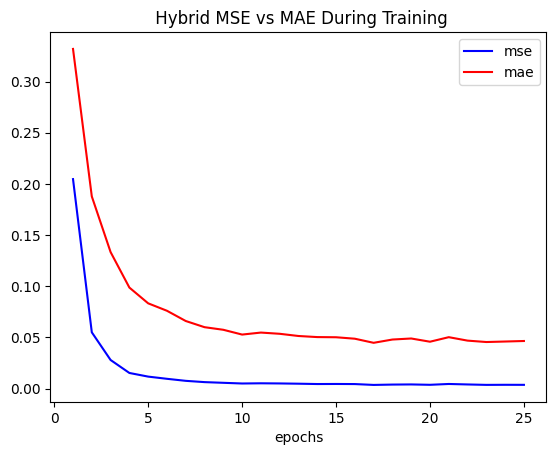

In [38]:
import matplotlib.pyplot as plt
x=np.arange(1,len(hybrid1.history['loss'])+1, 1)
plt.plot(x,hybrid1.history['loss'], "b", label= "mse")
plt.plot(x,hybrid1.history['mae'], "r", label= "mae")

plt.title(" Hybrid MSE vs MAE During Training")
plt.xlabel('epochs')
plt.legend()
plt.show()

## 2.4 Test Single Company Models (LSTM vs. Hybrid)

In [39]:
#Configure LSTM test using google data and micosoft validation data
print(test_data)
goog_test, goog_target = lstm_split(test_data, test_target, len(test_data))
LSTM_predictions = lstm.predict(goog_test)
LSTM_validation = lstm.predict(X_test).flatten()

#Generate google and microsoft test data for hybrid model
google_ft, google_target, goog_no_split = return_hybrid_data(lstm, Goog_data_proph, goog_test, goog_target)
hybrid_val_feat, hybrid_val_target, val_no_split = return_hybrid_data(lstm, Msft_test_proph, X_test, y_test)

#Generate linear predictions
linear_predictions_goog = linear_sing_hybrid.predict(goog_no_split)
linear_predictions_msft = linear_sing_hybrid.predict(val_no_split)

                open      high       low     close  adj_close    volume  \
date                                                                      
2016-01-04  0.031717  0.030282  0.029211  0.031365   0.031365  0.487561   
2016-01-05  0.033173  0.033633  0.032373  0.031681   0.031681  0.267259   
2016-01-06  0.026230  0.031599  0.028209  0.032124   0.032124  0.266642   
2016-01-07  0.026361  0.027936  0.023986  0.024779   0.024779  0.436056   
2016-01-08  0.026842  0.025712  0.021390  0.019698   0.019698  0.350607   
...              ...       ...       ...       ...        ...       ...   
2023-02-23  0.495796  0.493860  0.487063  0.491551   0.491551  0.212351   
2023-02-24  0.474694  0.476980  0.477211  0.476888   0.476888  0.202953   
2023-02-27  0.478577  0.479681  0.483636  0.483282   0.483282  0.131541   
2023-02-28  0.473935  0.488121  0.482865  0.484987   0.484987  0.196715   
2023-03-01  0.479168  0.486011  0.485692  0.486777   0.486777  0.161531   

              tenmda  tw

### 2.4.1 LSTM vs Hybrid predictions of Microsoft Validation Data

6/6 [==============================] - 0s 6ms/step


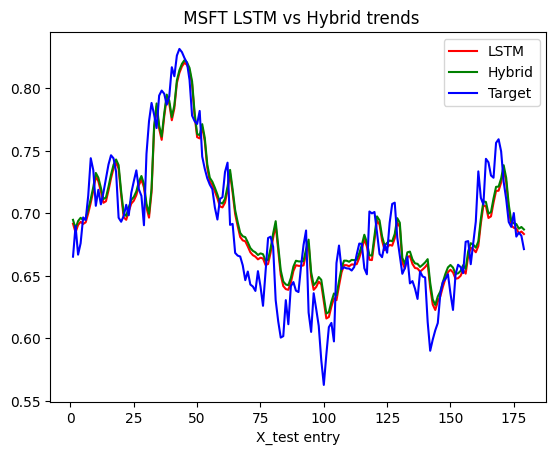

In [48]:
#ploting MSFT LSTM vs Hybrid predictions
import matplotlib.pyplot as plt
hybrid_MSFT_predictions = hybrid1.model.predict(hybrid_val_feat)

x=np.arange(1,len(LSTM_validation)+1,1)
plt.plot(x, LSTM_validation, "r", label= "LSTM")
plt.plot(x,linear_predictions_msft, "g", label= "Hybrid")
plt.plot(x,y_test, "b", label= "Target")

plt.title(" MSFT LSTM vs Hybrid trends")
plt.xlabel('X_test entry')
plt.legend()
plt.show()

**From the graph above we can see that the performance of the hybrid model(green) on validation data has reduced accuracy compared to the LSTM model (red)**

### 2.4.2 Google Predicitions on Microsoft Model ( LSTM vs Hybrid)

56/56 [==============================] - 0s 7ms/step


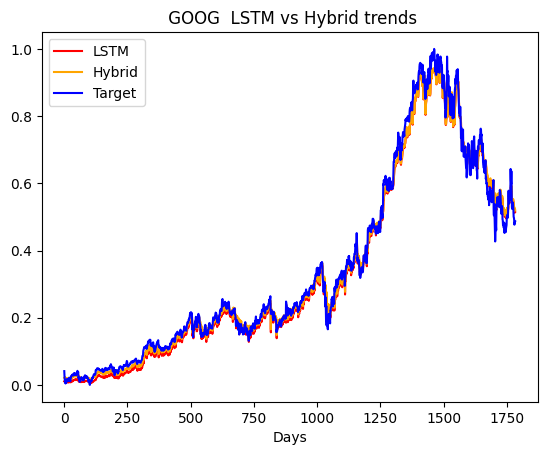

In [49]:
#ploting GOOG LSTM vs Hybrid predictions
import matplotlib.pyplot as plt
goog_predictions_hybrid = hybrid1.model.predict(google_ft)

x=np.arange(1,len(LSTM_predictions[10:])+1,1)
plt.plot(x, LSTM_predictions[10:], "r", label= "LSTM")
plt.plot(x,linear_predictions_goog[10:], "orange", label= "Hybrid")
plt.plot(x,goog_target[10:], "b", label= "Target")

plt.title(" GOOG  LSTM vs Hybrid trends")
plt.xlabel('Days')
plt.legend()
plt.show()

F**rom the graph above we can see that the performance of the hybrid model(orange) for an unseen stock (GOOG) has reduced accuracy compared to the LSTM model (red)**

In [50]:
def compute_metrics(true_series, forecast):
    """Helper to print MSE and MAE"""
    rmse = tf.keras.metrics.RootMeanSquaredError()
    rmse.update_state(true_series, forecast)
    mae = tf.keras.metrics.MeanAbsoluteError()
    mae.update_state(true_series, forecast)
    print(f"the root mean square error of the predictions is {rmse.result().numpy()}, and the mean absolute error of the predictions is {mae.result().numpy()}")
    return rmse.result().numpy(), mae.result().numpy()

# 3.0 Building the Expanded Hybrid Model

In [51]:
LR = 0.01 
def create_data_lists(list_of_feats, list_of_targets):
  training_list = []
  target_list = []
  for data, target in zip(list_of_feats, list_of_targets):
    data_x, data_y = lstm_split(data, target, len(data))
    print(data_x.shape)
    training_list.append(data_x)
    target_list.append(data_y)
  return training_list, target_list

#Train each of the lstm models on training companies
path = '/content/BigData/Project_Deliverables_PansyAhmed_AdamGreen/expanded_data/'
ticker_list = ["MSFT", "NFLX", "AMZN", "TSLA"]
hybrid_scalers, targets, frames = scale(path)
training_list, target_list = create_data_lists(frames, targets)

for tick, x_train, y_train in zip(ticker_list, training_list, target_list):
  model = multiple_models(x_train, y_train)
  model.model.save('sub_models/'+tick+'_lstm.h5')

MSFT_dataframe.csv
NFLX_dataframe.csv
TSLA_dataframe.csv
AMZN_dataframe.csv
(1792, 10, 18)
(1792, 10, 18)
(1792, 10, 18)
(1792, 10, 18)
Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


75/75 [==============================] - 2s 10ms/step - loss: 0.1271 - mae: 0.2415
Epoch 2/200
75/75 [==============================] - 1s 10ms/step - loss: 0.0248 - mae: 0.1254
Epoch 3/200
75/75 [==============================] - 1s 10ms/step - loss: 0.0164 - mae: 0.1016
Epoch 4/200
75/75 [==============================] - 1s 10ms/step - loss: 0.0121 - mae: 0.0869
Epoch 5/200
75/75 [==============================] - 1s 10ms/step - loss: 0.0096 - mae: 0.0775
Epoch 6/200
75/75 [==============================] - 1s 10ms/step - loss: 0.0081 - mae: 0.0690
Epoch 7/200
75/75 [==============================] - 1s 10ms/step - loss: 0.0071 - mae: 0.0648
Epoch 8/200
75/75 [==============================] - 1s 10ms/step - loss: 0.0059 - mae: 0.0589
Epoch 9/200
75/75 [==============================] - 1s 10ms/step - loss: 0.0053 - mae: 0.0558
Epoch 10/200
75/75 [==============================] - 1s 15ms/step - loss: 0.0050 - mae: 0.0535
Epoch 11/200
75/75 [==============================] - 1s 15ms

## 3.1 Train Expanded Hybrid Model Using Predictions of all Sub-Models

In [52]:
#Create Train Data for Hybrid Model Using Microsoft Predictions
from keras.saving.legacy.save import load_model
import os
def hybrid_trainer(direct, ticker_list, hybrid_train):
    preds_dict = {}
    path = direct
    for num, model in enumerate(os.listdir(path)):
        model = load_model(path+model)
        prediction = model.predict(hybrid_train).flatten()
        print(prediction.shape)
        preds_dict[ticker_list[num]] = prediction
    preds_df = pd.DataFrame(preds_dict)
    return preds_df

#generate training data for expanded hybrid model
hybrid_training_data =  hybrid_trainer('sub_models/', ticker_list, X_train) 
hybrid_training_data['prophet'] = np.array(Msft_train_proph)
linear_training_data = hybrid_training_data
hybrid_training_data, y_train = lstm_split(hybrid_training_data, target_list[0], len(hybrid_training_data))


51/51 [==============================] - 1s 6ms/step
(1613,)
51/51 [==============================] - 1s 6ms/step
(1613,)
51/51 [==============================] - 0s 4ms/step
(1613,)
51/51 [==============================] - 0s 4ms/step
(1613,)


In [ ]:
#Create and train the expanded hybrid model
hybrid_expanded = multiple_models(hybrid_training_data, y_train)
hybrid_expanded.model.save('main_models/hybrid_expanded.h5')

In [55]:
expanded_linear_model = create_linear(linear_training_data[10:], y_train)

## 3.2 Test the Expanded Hybrid Model on Microsoft and Goole Test Data


In [56]:
#Configure hybrid model testing data based on predictions from each of the four underlying models and prophet
google_test = {}
microsoft_test = {}
path = 'sub_models/'
for num, model in enumerate(os.listdir(path)):
  model = load_model(path+model)
  goog_preds = model.predict(goog_test).flatten()
  micro_preds = model.predict(X_test).flatten()
  google_test[ticker_list[num]] = goog_preds
  microsoft_test[ticker_list[num]] = micro_preds
google_test = pd.DataFrame(google_test)
microsoft_test = pd.DataFrame(microsoft_test)

#set Prophet data
google_test['prophet'] = np.array(Goog_data_proph)
microsoft_test['prophet'] = np.array(Msft_test_proph)
linear_test_goog = google_test
linear_test_msft = microsoft_test
#Create final test data for hybrid model
google_test, goog_y = lstm_split(google_test, goog_target, len(google_test))
microsoft_test, msft_y = lstm_split(microsoft_test, y_test, len(microsoft_test))

6/6 [==============================] - 0s 5ms/step


In [57]:
#Predict google and microsoft test data using the trained hybrid model
hybrid_expanded = load_model('main_models/hybrid_expanded.h5')
expanded_msft_predictions = hybrid_expanded.predict(microsoft_test)
expanded_goog_predictions = hybrid_expanded.predict(google_test)
linear_expanded_predictions_goog = expanded_linear_model.predict(linear_test_goog)
linear_expanded_predictions_msft = expanded_linear_model.predict(linear_test_msft)

56/56 [==============================] - 0s 4ms/step


In [68]:
#prepare all predictions
#lstm
print('single LSTM model')
msft_lstm_rmse, msft_lstm_mae = compute_metrics(scaler_list[0].inverse_transform([y_test]),scaler_list[0].inverse_transform(LSTM_MSFT_test))
goog_lstm_rmse, goog_lstm_mae = compute_metrics(scaler_list[1].inverse_transform([google_target]), scaler_list[1].inverse_transform(LSTM_predictions))

print('single hybrid model')
#single hybrid
msft_single_rmse, msft_single_mae = compute_metrics(scaler_list[0].inverse_transform([y_test[10:]]), scaler_list[0].inverse_transform(hybrid_MSFT_predictions))
goog_single_rmse, goog_single_mae = compute_metrics(scaler_list[1].inverse_transform([google_target]),scaler_list[1].inverse_transform(goog_predictions_hybrid))

print('single linear model')
#Single linear hybrid
msft_sing_linear_rmse, msft_sing_linear_mae = compute_metrics(scaler_list[0].inverse_transform([y_test]),scaler_list[0].inverse_transform([linear_predictions_msft]))
goog_linear_rmse, goog_linear_mae = compute_metrics(scaler_list[1].inverse_transform([google_target]), scaler_list[1].inverse_transform([linear_predictions_goog[10:]]))

print('expanded hybrid model')
#expanded_hybrid
msft_expanded_rmse, msft_expanded_mae = compute_metrics(scaler_list[0].inverse_transform([msft_y]), scaler_list[0].inverse_transform(expanded_msft_predictions))
goog_expanded_rmse, goog_expanded_mae = compute_metrics(scaler_list[1].inverse_transform([goog_y]), scaler_list[1].inverse_transform(expanded_goog_predictions))

print('expanded linear model')
#Expanded linear hybrid
msft_exlin_rmse, msft_exlin_mae = compute_metrics(scaler_list[0].inverse_transform([y_test]), scaler_list[0].inverse_transform([linear_expanded_predictions_msft]))
goog_exlin_rmse, goog_exlin_mae = compute_metrics(scaler_list[1].inverse_transform([google_target]), scaler_list[1].inverse_transform([linear_expanded_predictions_goog[10:]]))

single LSTM model
the mean square error of the predictions is 452.7202453613281, and the mean absolute error of the predictions is 16.73552703857422
the mean square error of the predictions is 2163.543212890625, and the mean absolute error of the predictions is 36.247962951660156
single hybrid model
the mean square error of the predictions is 465.6942443847656, and the mean absolute error of the predictions is 17.38759994506836
the mean square error of the predictions is 1938.7657470703125, and the mean absolute error of the predictions is 34.265506744384766
single linear model
the mean square error of the predictions is 55.34576416015625, and the mean absolute error of the predictions is 5.864438056945801
the mean square error of the predictions is 7.368976593017578, and the mean absolute error of the predictions is 1.9178004264831543
expanded hybrid model
the mean square error of the predictions is 550.6950073242188, and the mean absolute error of the predictions is 18.61594581604004

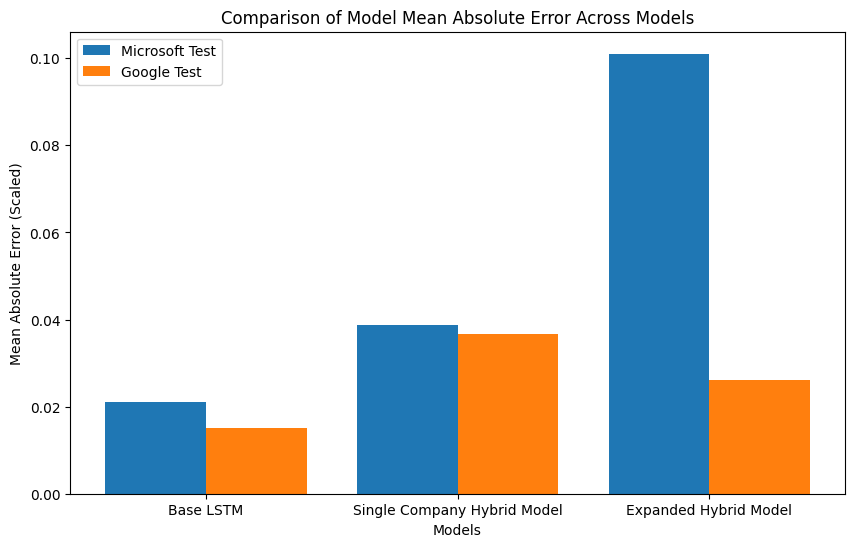

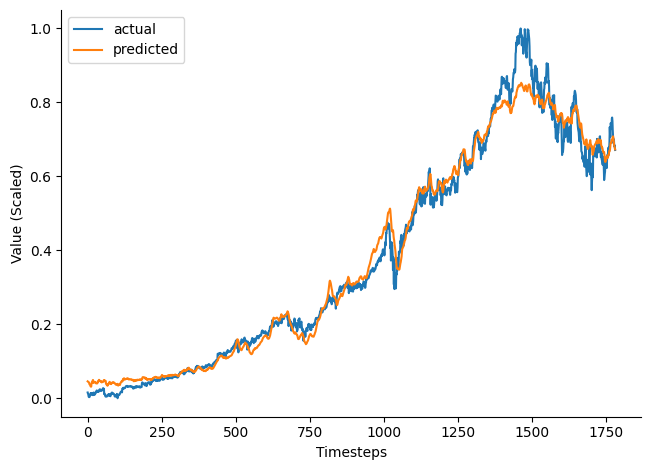

In [ ]:
import seaborn as sns
x = ['Base LSTM', 'Single Company Hybrid Model', "Expanded Hybrid Model"]
msft = [msft_lstm_mae, msft_single_mae, msft_expanded_mae]
goog = [goog_lstm_mae, goog_single_mae, goog_expanded_mae]
X_axis = np.arange(len(x))
plt.figure(figsize=(10, 6))
plt.bar(X_axis - 0.2, msft, 0.4, label = 'Microsoft Test')
plt.bar(X_axis + 0.2, goog, 0.4, label = 'Google Test')
  
plt.xticks(X_axis, x)
plt.xlabel("Models")
plt.ylabel("Mean Absolute Error (Scaled)")
plt.title("Comparison of Model Mean Absolute Error Across Models")
plt.legend()
plt.show()


plt.plot(goog_y, label="actual")
plt.plot(expanded_goog_predictions, label="predicted")
goog_y, expanded_goog_predictions
plt.xlabel("Timesteps")
plt.ylabel("Value (Scaled)")
plt.tight_layout()
sns.despine(top=True)
plt.subplots_adjust(left=0.07)
plt.legend()
plt.show() 